### Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

Cloning into 'OpticalEncoder'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 318 (delta 176), reused 248 (delta 106), pack-reused 0
Receiving objects: 100% (318/318), 5.26 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [3]:
%pip install belashovplot

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=6a2292ad0cbea1f3c35f45a9faf29bf803e5b8e6bb7dfd2cc3ba79fbe96eb6e4
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [55]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.modulators import Lens, PhaseModulator
from elements.propagators import FurrierPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy

### Цель эксперемента

Целью данного эксперемента является задание системы ...

### Настройка некогерентности

In [56]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20 #100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм


## Система без линз

Описание системы

### Настройка параметров системы

In [57]:
length = 3.0E-3
wavelength = 500E-9
mask_unit_length = 20.0E-6
masks_amount = 3
cppp = 3

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 1.0

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       453
Количество пикселей маски:                151
Количество модуляторов:                   3
Размер оптических элементов:              3.0 мм
Размер пикселя маски:                     20.0 мкм
Расстояние между слоями:                  119.962 мм


### Отрисовка некогерентности

0.002447230741381645 0.48211465664062503
0.00017678692529443651 0.2975162139490659
0.00016014154243748635 0.09179963349316649
5.522275387193076e-05 0.11330034888011054
7.143818947952241e-05 0.13983682252184965
4.311084558139555e-05 0.17258849709014415
6.11882351222448e-05 0.21301105667772507
4.592713958118111e-05 0.13145056313707282
3.7431789678521454e-05 9.564287257458841e-13
Parameter containing:
tensor([0.1361, 0.4511, 1.0064, 1.0077], device='cuda:0')


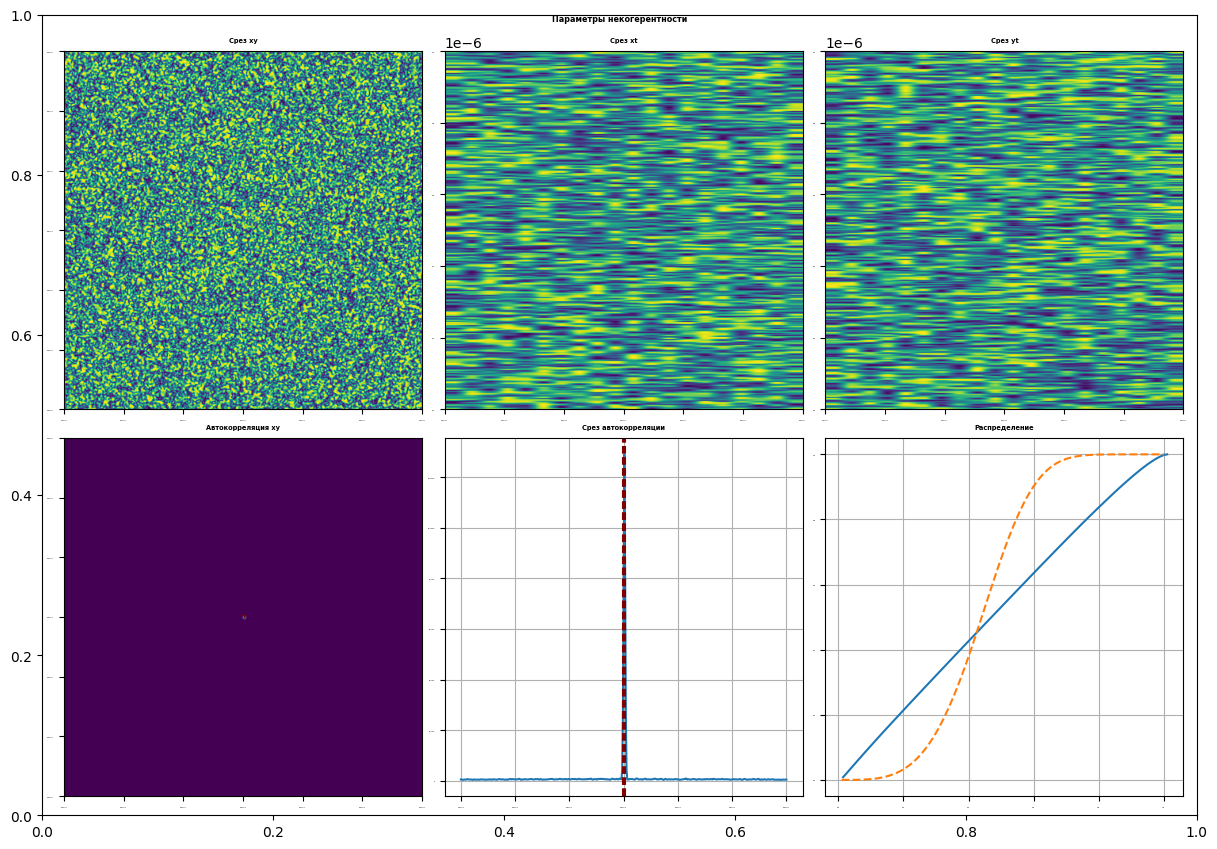

In [58]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [59]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.7)
modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
elements = [modulators[0]]
for modulator in modulators[1:]:
    elements.append(propagation)
    elements.append(modulator)
elements.append(propagation)

chunker = CudaMemoryChunker()

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): FurrierPropagation()
  (Element2): PhaseModulator()
  (Element3): FurrierPropagation()
  (Element4): PhaseModulator()
  (Element5): FurrierPropagation()
  (Wrapper0): CudaMemoryChunker()
  (Wrapper1): Incoherent(
    (_generator): GaussianNormalizer(
      (_generator): FourierMask()
    )
  )
)

### Инициализация детекторов

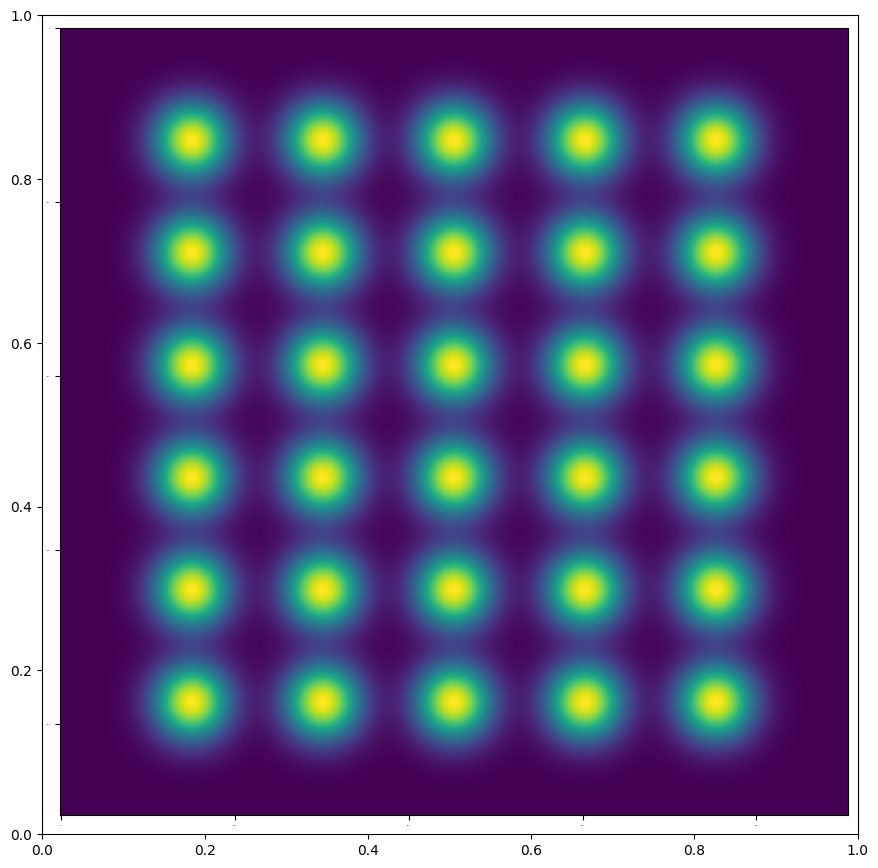

In [60]:
detectors_amount = 30

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/30, length/30), (0,0))
detectors = ClassificationDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).imshow(torch.sum(detectors.filter, dim=0), aspect='auto')
plot.show()

### Инициализация электронной модели

In [61]:
layers_structure = [detectors_amount, 15, 10]

layers = []
for nodes0, nodes1 in zip(layers_structure[:-1], layers_structure[1:]):
    layers.append(torch.nn.Linear(nodes0, nodes1))
    layers.append(torch.nn.Sigmoid())
electronic = torch.nn.Sequential(*layers[:-1])
electronic.to(optical.device)

Sequential(
  (0): Linear(in_features=30, out_features=15, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=15, out_features=10, bias=True)
)

### Инициализация гибридной модели

In [62]:
image, _ = Dataset.single('STL10', N, N, torch.complex64)
image = image.to(optical.device)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 6/6 [00:00<00:00, 10.72it/s]


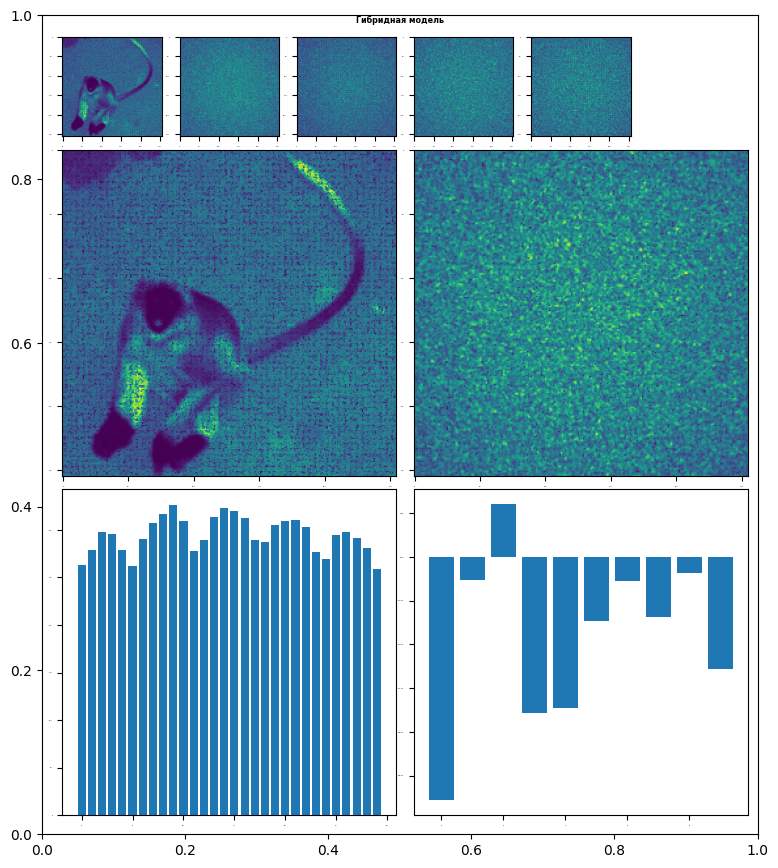

In [63]:
model = HybridModel(optical, detectors, electronic)
model.visualize(image)

### Инициализация набора данных

In [64]:
dataset = Dataset('STL10', 50, N, N, torch.complex64)
dataset.train
dataset.test

Files already downloaded and verified
Files already downloaded and verified


### Инициализация лосс функции и обучающего модуля

In [65]:
def plot_confusion_matrix(cm, class_names=None):
    if class_names is None:
      class_names = [str(i+1) for i in range(cm.shape[0])]
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    ax = plot.axes.add(0,0)

    # Отображение всех тиков.
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # Названия тиков.
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Цикл по размерам данных и создание текстовых аннотаций.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plot.show()

In [66]:
CrossEntropy = torch.nn.CrossEntropyLoss()
def loss_function(results:torch.Tensor, labels0:torch.Tensor):
    return CrossEntropy(results, labels0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def epoch():
    model.train()
    torch.cuda.empty_cache()
    history = []
    iterator = tqdm(dataset.test)
    for images, labels in iterator:
        optimizer.zero_grad()

        labels = labels.to(model.device)
        results = []
        for image in images:
            image = image.unsqueeze(0).to(model.device)
            image = model.forward(image)
            results.append(image[0])
            image = image.to(torch.device('cpu'))

        loss = loss_function(torch.stack(results, dim=0), labels)
        loss.backward()
        optimizer.step()

        history.append(loss.item())
        iterator.set_description(f"Loss: {loss.item()}")
        iterator.refresh()
    return history

def accuracy():
    model.eval()
    torch.cuda.empty_cache()
    confusion = torch.zeros((10, 10), device=model.device)
    with torch.no_grad():
        iterator = tqdm(dataset.train)
        for images, labels in iterator:
            labels = labels.to(model.device)
            results = []
            for image in images:
                image = image.unsqueeze(0).to(model.device)
                result = model.forward(image)
                results.append(result[0])
                image = image.to(torch.device('cpu'))
            results = torch.stack(results, dim=0)
            values, indexes = torch.max(results, dim=1)
            for label, index in zip(labels, indexes):
                confusion[label.item(), index.item()] += 1
    return confusion.cpu()

## Обучение модели

In [67]:
history = []

### Эпоха №1

In [ ]:
history += epoch()

Loss: 2.3222272396087646:  20%|██        | 32/160 [05:38<22:33, 10.57s/it]

In [ ]:
model.visualize(image)

In [ ]:
confusion = accuracy()
plot_confusion_matrix(confusion)

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).plot(history)
# plot.axes.add(0,0).imshow(image.cpu().abs()[0][0]**2)
plot.show()

In [45]:
print(history)

[2.2833411693573, 2.3338446617126465, 2.3212006092071533, 2.3190510272979736, 2.2772464752197266, 2.355036735534668, 2.2731242179870605, 2.356321334838867, 2.3185906410217285, 2.3259193897247314, 2.3250153064727783, 2.3138961791992188, 2.2898378372192383, 2.3412508964538574, 2.3141655921936035, 2.283720016479492, 2.332160711288452, 2.2981560230255127, 2.343768835067749, 2.3461992740631104, 2.253586769104004, 2.3003244400024414, 2.3298914432525635, 2.3385250568389893, 2.3563878536224365, 2.3023831844329834, 2.305318832397461, 2.321392297744751, 2.2937984466552734, 2.309293746948242, 2.3483638763427734, 2.3118181228637695, 2.316345453262329, 2.294220209121704, 2.297584295272827, 2.3069303035736084, 2.321028709411621, 2.3189051151275635, 2.2880239486694336, 2.329233407974243, 2.315708875656128, 2.2718567848205566, 2.27624249458313, 2.301426887512207, 2.3163418769836426, 2.361377477645874, 2.3357388973236084, 2.301679849624634, 2.328808546066284, 2.319952964782715, 2.3141708374023438, 2.29